<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/HEALTHCARE_AI_AGENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [36]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)
llm.invoke("im naveed")

AIMessage(content="It's nice to meet you, Naveed.  Is there anything I can help you with today?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-dd1288c8-896b-4511-9f60-2a333baf20ab-0', usage_metadata={'input_tokens': 4, 'output_tokens': 23, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}})

In [37]:
import os
from google.colab import userdata
LANGCHAIN_API_KEY = userdata.get('langchain')
# Use os.environ to access and modify environment variables
os.environ["langchain"] = LANGCHAIN_API_KEY
os.environ["langchain"] = "true"
os.environ["langchain"] = "langchain"

In [48]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()

In [68]:
# ... (previous code)

# Define the functions for your tools

# ... (other functions)

def check_symptoms(symptoms: list[str]) -> str:  # Change here: Add type hint for symptoms
    """Check symptoms and provide potential diagnosis."""
    try:
        conditions = []
        if "fever" in symptoms and "cough" in symptoms:
            conditions.append("Possible flu or respiratory infection.")
        if "chest pain" in symptoms:
            conditions.append("Risk of heart issues, consult a cardiologist.")
        if "headache" in symptoms and "blurred vision" in symptoms:
            conditions.append("Possible migraine or neurological issue.")

        return " | ".join(conditions) if conditions else "No immediate conditions detected."
    except Exception as e:
        return f"Error checking symptoms: {e}"

# ... (rest of the code)

# LLM setup and binding tools
# Assuming 'llm' is your ChatGoogleGenerativeAI instance

from typing import Any, Dict, List, Optional, Union

from langchain.tools import tool

@tool
def check_symptoms(symptoms: str) -> str:
    """Check symptoms and provide potential diagnosis."""
    try:
        symptoms_list = symptoms.split(",") # Assuming comma-separated symptoms
        conditions = []
        if "fever" in symptoms_list and "cough" in symptoms_list:
            conditions.append("Possible flu or respiratory infection.")
        if "chest pain" in symptoms_list:
            conditions.append("Risk of heart issues, consult a cardiologist.")
        if "headache" in symptoms_list and "blurred vision" in symptoms_list:
            conditions.append("Possible migraine or neurological issue.")

        return " | ".join(conditions) if conditions else "No immediate conditions detected."
    except Exception as e:
        return f"Error checking symptoms: {e}"

tools = [calculate_bmi, analyze_blood_pressure, check_symptoms, age_based_risk]


llm_with_tools = llm.bind_tools(tools)

# ... (rest of the code)

In [69]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x79b44b88ded0>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'calculate_bmi', 'description': 'Calculate BMI and provide health assessment.', 'parameters': {'properties': {'weight': {'type': 'number'}, 'height': {'type': 'number'}}, 'required': ['weight', 'height'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'analyze_blood_pressure', 'description': 'Analyze blood pressure readings.', 'parameters': {'properties': {'bp_systolic': {'type': 'integer'}, 'bp_diastolic': {'type': 'integer'}}, 'required': ['bp_systolic', 'bp_diastolic'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'check_symptoms', 'description': 'Check symptoms and provide potential diagnosis.', 'parameters': {'properties': 

In [70]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState) -> MessagesState:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [71]:
# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",

    tools_condition,
)
builder.add_edge("tools", "assistant")
graph = builder.compile(checkpointer=memory)

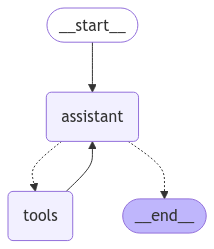

In [72]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [73]:
from langchain.schema.messages import HumanMessage , AIMessage , ToolMessage


In [74]:
config1 = {"configurable": {"thread_id": "1"}}

In [75]:
messages = graph.invoke({"messages": [HumanMessage(content="Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================== Ai Message ==================================
Tool Calls:
  calculate_bmi (bc36cf5b-c3a0-4bfc-b5cd-5dd1552e5b8a)
 Call ID: bc36cf5b-c3a0-4bfc

In [76]:
messages = graph.invoke({"messages": [HumanMessage(content="Analyze blood pressure for systolic 135 and diastolic 85")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================== Ai Message ==================================
Tool Calls:
  calculate_bmi (bc36cf5b-c3a0-4bfc-b5cd-5dd1552e5b8a)
 Call ID: bc36cf5b-c3a0-4bfc

In [77]:
messages = graph.invoke({"messages": [HumanMessage(content="Assess health risks for a 45-year-old patient")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================== Ai Message ==================================
Tool Calls:
  calculate_bmi (bc36cf5b-c3a0-4bfc-b5cd-5dd1552e5b8a)
 Call ID: bc36cf5b-c3a0-4bfc

In [78]:
messages = graph.invoke({"messages": [HumanMessage(content="Calculate BMI for weight 92kg and height 1.70m, and analyze blood pressure for systolic 145 and diastolic 95")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================== Ai Message ==================================
Tool Calls:
  calculate_bmi (bc36cf5b-c3a0-4bfc-b5cd-5dd1552e5b8a)
 Call ID: bc36cf5b-c3a0-4bfc

In [79]:
messages = graph.invoke({"messages": [HumanMessage(content="Analyze a 55-year-old patient. Calculate BMI for weight 90kg and height 1.65m, analyze blood pressure for systolic 150 and diastolic 95, assess symptoms: fever, cough, and chest pain, and provide age-based health risk assessment.")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================ Human Message =================================

Analyze patient data for BMI and blood pressure. Patient details: weight=70, height=1.75, bp_systolic=130, bp_diastolic=85.
================================== Ai Message ==================================
Tool Calls:
  calculate_bmi (bc36cf5b-c3a0-4bfc-b5cd-5dd1552e5b8a)
 Call ID: bc36cf5b-c3a0-4bfc